## Crassification Bot
　　　From SIGNATE　【練習問題】ボットの判別

In [1]:
# 基本ライブラリの読み込み
import numpy as np
import pandas as pd
import seaborn as sns

### trainデータ

In [2]:
# train.tsvの読み込み
df_train = pd.read_csv("train.tsv", sep="\t")
df_train.head()

,id,bot,statuses_count,default_profile,default_profile_image,friends_count,followers_count,favourites_count,geo_enabled,listed_count,account_age_hours,diversity,mean_mins_between_tweets,mean_tweet_length,mean_retweets,reply_rate
0,0,0,715,0,0,423,206,150,1,34,36981,0.684902,3958.863636,97.513514,1.473684,0.504505
1,2,0,2151,0,0,1457,1321,1704,1,90,35603,0.704787,2746.533708,69.988827,3.814815,0.553073
2,3,0,439,0,0,691,213,5,0,15,38432,0.528857,11005.031847,75.101266,1.142857,0.158228
3,7,0,28,1,0,285,31,0,0,1,4898,0.810427,6495.666667,93.029412,3.000000,0.029412
4,12,0,40,0,0,907,60,1013,1,2,47238,0.831579,112167.300000,79.142857,1.000000,0.047619


In [3]:
# インデックスとbot（目的変数）を説明変数から削除してtrainXに代入する
trainX = df_train.iloc[:, 2:]
trainX.head()

,statuses_count,default_profile,default_profile_image,friends_count,followers_count,favourites_count,geo_enabled,listed_count,account_age_hours,diversity,mean_mins_between_tweets,mean_tweet_length,mean_retweets,reply_rate
0,715,0,0,423,206,150,1,34,36981,0.684902,3958.863636,97.513514,1.473684,0.504505
1,2151,0,0,1457,1321,1704,1,90,35603,0.704787,2746.533708,69.988827,3.814815,0.553073
2,439,0,0,691,213,5,0,15,38432,0.528857,11005.031847,75.101266,1.142857,0.158228
3,28,1,0,285,31,0,0,1,4898,0.810427,6495.666667,93.029412,3.000000,0.029412
4,40,0,0,907,60,1013,1,2,47238,0.831579,112167.300000,79.142857,1.000000,0.047619


In [4]:
trainX.describe()

,statuses_count,default_profile,default_profile_image,friends_count,followers_count,favourites_count,geo_enabled,listed_count,account_age_hours,diversity,mean_mins_between_tweets,mean_tweet_length,mean_retweets,reply_rate
count,1588.000000,1588.000000,1588.000000,1588.000000,1.588000e+03,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1.588000e+03,1588.000000,1588.000000,1588.000000
mean,3188.091310,0.294710,0.030856,1595.297229,2.909536e+03,1005.797859,0.447733,84.814232,43666.015743,0.676168,1.419424e+04,92.204547,2.918117,0.343931
std,8297.720077,0.456056,0.172983,12335.033788,3.391030e+04,4246.563718,0.497417,369.136188,17798.660934,0.141481,5.496563e+04,19.779600,19.489098,0.248255
min,0.000000,0.000000,0.000000,16.000000,1.000000e+00,0.000000,0.000000,0.000000,2744.000000,0.005000,-1.565449e+01,13.166667,1.000000,0.000000
25%,198.500000,0.000000,0.000000,303.500000,9.975000e+01,16.000000,0.000000,4.000000,30575.500000,0.625356,1.114957e+03,81.116807,1.166667,0.119915
50%,773.500000,0.000000,0.000000,635.000000,3.140000e+02,131.500000,0.000000,16.500000,47456.000000,0.693826,3.637171e+03,92.612121,1.651598,0.328980
75%,2682.750000,1.000000,0.000000,1229.000000,8.732500e+02,606.750000,1.000000,54.250000,56539.750000,0.762894,1.011626e+04,104.077862,2.451136,0.541176
max,137264.000000,1.000000,1.000000,373374.000000,1.141862e+06,113640.000000,1.000000,9491.000000,78841.000000,1.000000,1.139015e+06,287.875912,767.588235,1.000000


In [5]:
trainX.shape

(1588, 14)

In [6]:
trainX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1588 entries, 0 to 1587
Data columns (total 14 columns):
statuses_count              1588 non-null int64
default_profile             1588 non-null int64
default_profile_image       1588 non-null int64
friends_count               1588 non-null int64
followers_count             1588 non-null int64
favourites_count            1588 non-null int64
geo_enabled                 1588 non-null int64
listed_count                1588 non-null int64
account_age_hours           1588 non-null int64
diversity                   1588 non-null float64
mean_mins_between_tweets    1588 non-null float64
mean_tweet_length           1588 non-null float64
mean_retweets               1588 non-null float64
reply_rate                  1588 non-null float64
dtypes: float64(5), int64(9)
memory usage: 173.8 KB


In [7]:
trainX.isnull().sum()

statuses_count              0
default_profile             0
default_profile_image       0
friends_count               0
followers_count             0
favourites_count            0
geo_enabled                 0
listed_count                0
account_age_hours           0
diversity                   0
mean_mins_between_tweets    0
mean_tweet_length           0
mean_retweets               0
reply_rate                  0
dtype: int64

In [8]:
# 項目間の相関を確認
df_train.corr()

,id,bot,statuses_count,default_profile,default_profile_image,friends_count,followers_count,favourites_count,geo_enabled,listed_count,account_age_hours,diversity,mean_mins_between_tweets,mean_tweet_length,mean_retweets,reply_rate
id,1.000000,0.021782,0.015923,0.053258,-0.003672,0.005114,0.009893,0.031527,-0.020958,0.019699,0.007482,-0.036990,-0.012682,0.000057,-0.015360,-0.026738
bot,0.021782,1.000000,-0.127216,0.339105,0.399564,-0.024027,-0.033112,-0.078671,-0.252564,-0.075608,-0.229746,0.112604,0.253207,-0.129651,-0.024273,-0.082452
statuses_count,0.015923,-0.127216,1.000000,-0.144709,-0.066344,0.295279,0.237502,0.309038,0.074858,0.303930,0.189305,-0.071162,-0.089360,-0.017772,0.008460,0.138921
default_profile,0.053258,0.339105,-0.144709,1.000000,0.228111,-0.037176,-0.044361,-0.099137,-0.184825,-0.106799,-0.272503,0.022354,0.152235,-0.054538,-0.020206,-0.023419
default_profile_image,-0.003672,0.399564,-0.066344,0.228111,1.000000,-0.007195,-0.015204,-0.039541,-0.124046,-0.040419,-0.102719,0.050489,0.258645,-0.155200,-0.013989,-0.023842
friends_count,0.005114,-0.024027,0.295279,-0.037176,-0.007195,1.000000,0.922871,0.123385,0.005181,0.348717,0.031618,-0.074305,-0.015428,0.028831,0.013843,-0.010471
followers_count,0.009893,-0.033112,0.237502,-0.044361,-0.015204,0.922871,1.000000,0.098982,0.014417,0.405729,0.035094,-0.062057,-0.020385,0.033969,0.042584,-0.002805
favourites_count,0.031527,-0.078671,0.309038,-0.099137,-0.039541,0.123385,0.098982,1.000000,0.040742,0.200756,0.111353,0.003540,-0.053377,-0.036438,0.006687,0.105890
geo_enabled,-0.020958,-0.252564,0.074858,-0.184825,-0.124046,0.005181,0.014417,0.040742,1.000000,0.041562,0.307193,-0.041680,-0.110201,-0.057954,-0.022539,0.096960
listed_count,0.019699,-0.075608,0.303930,-0.106799,-0.040419,0.348717,0.405729,0.200756,0.041562,1.000000,0.159773,-0.037145,-0.051144,0.030659,0.048199,0.065247


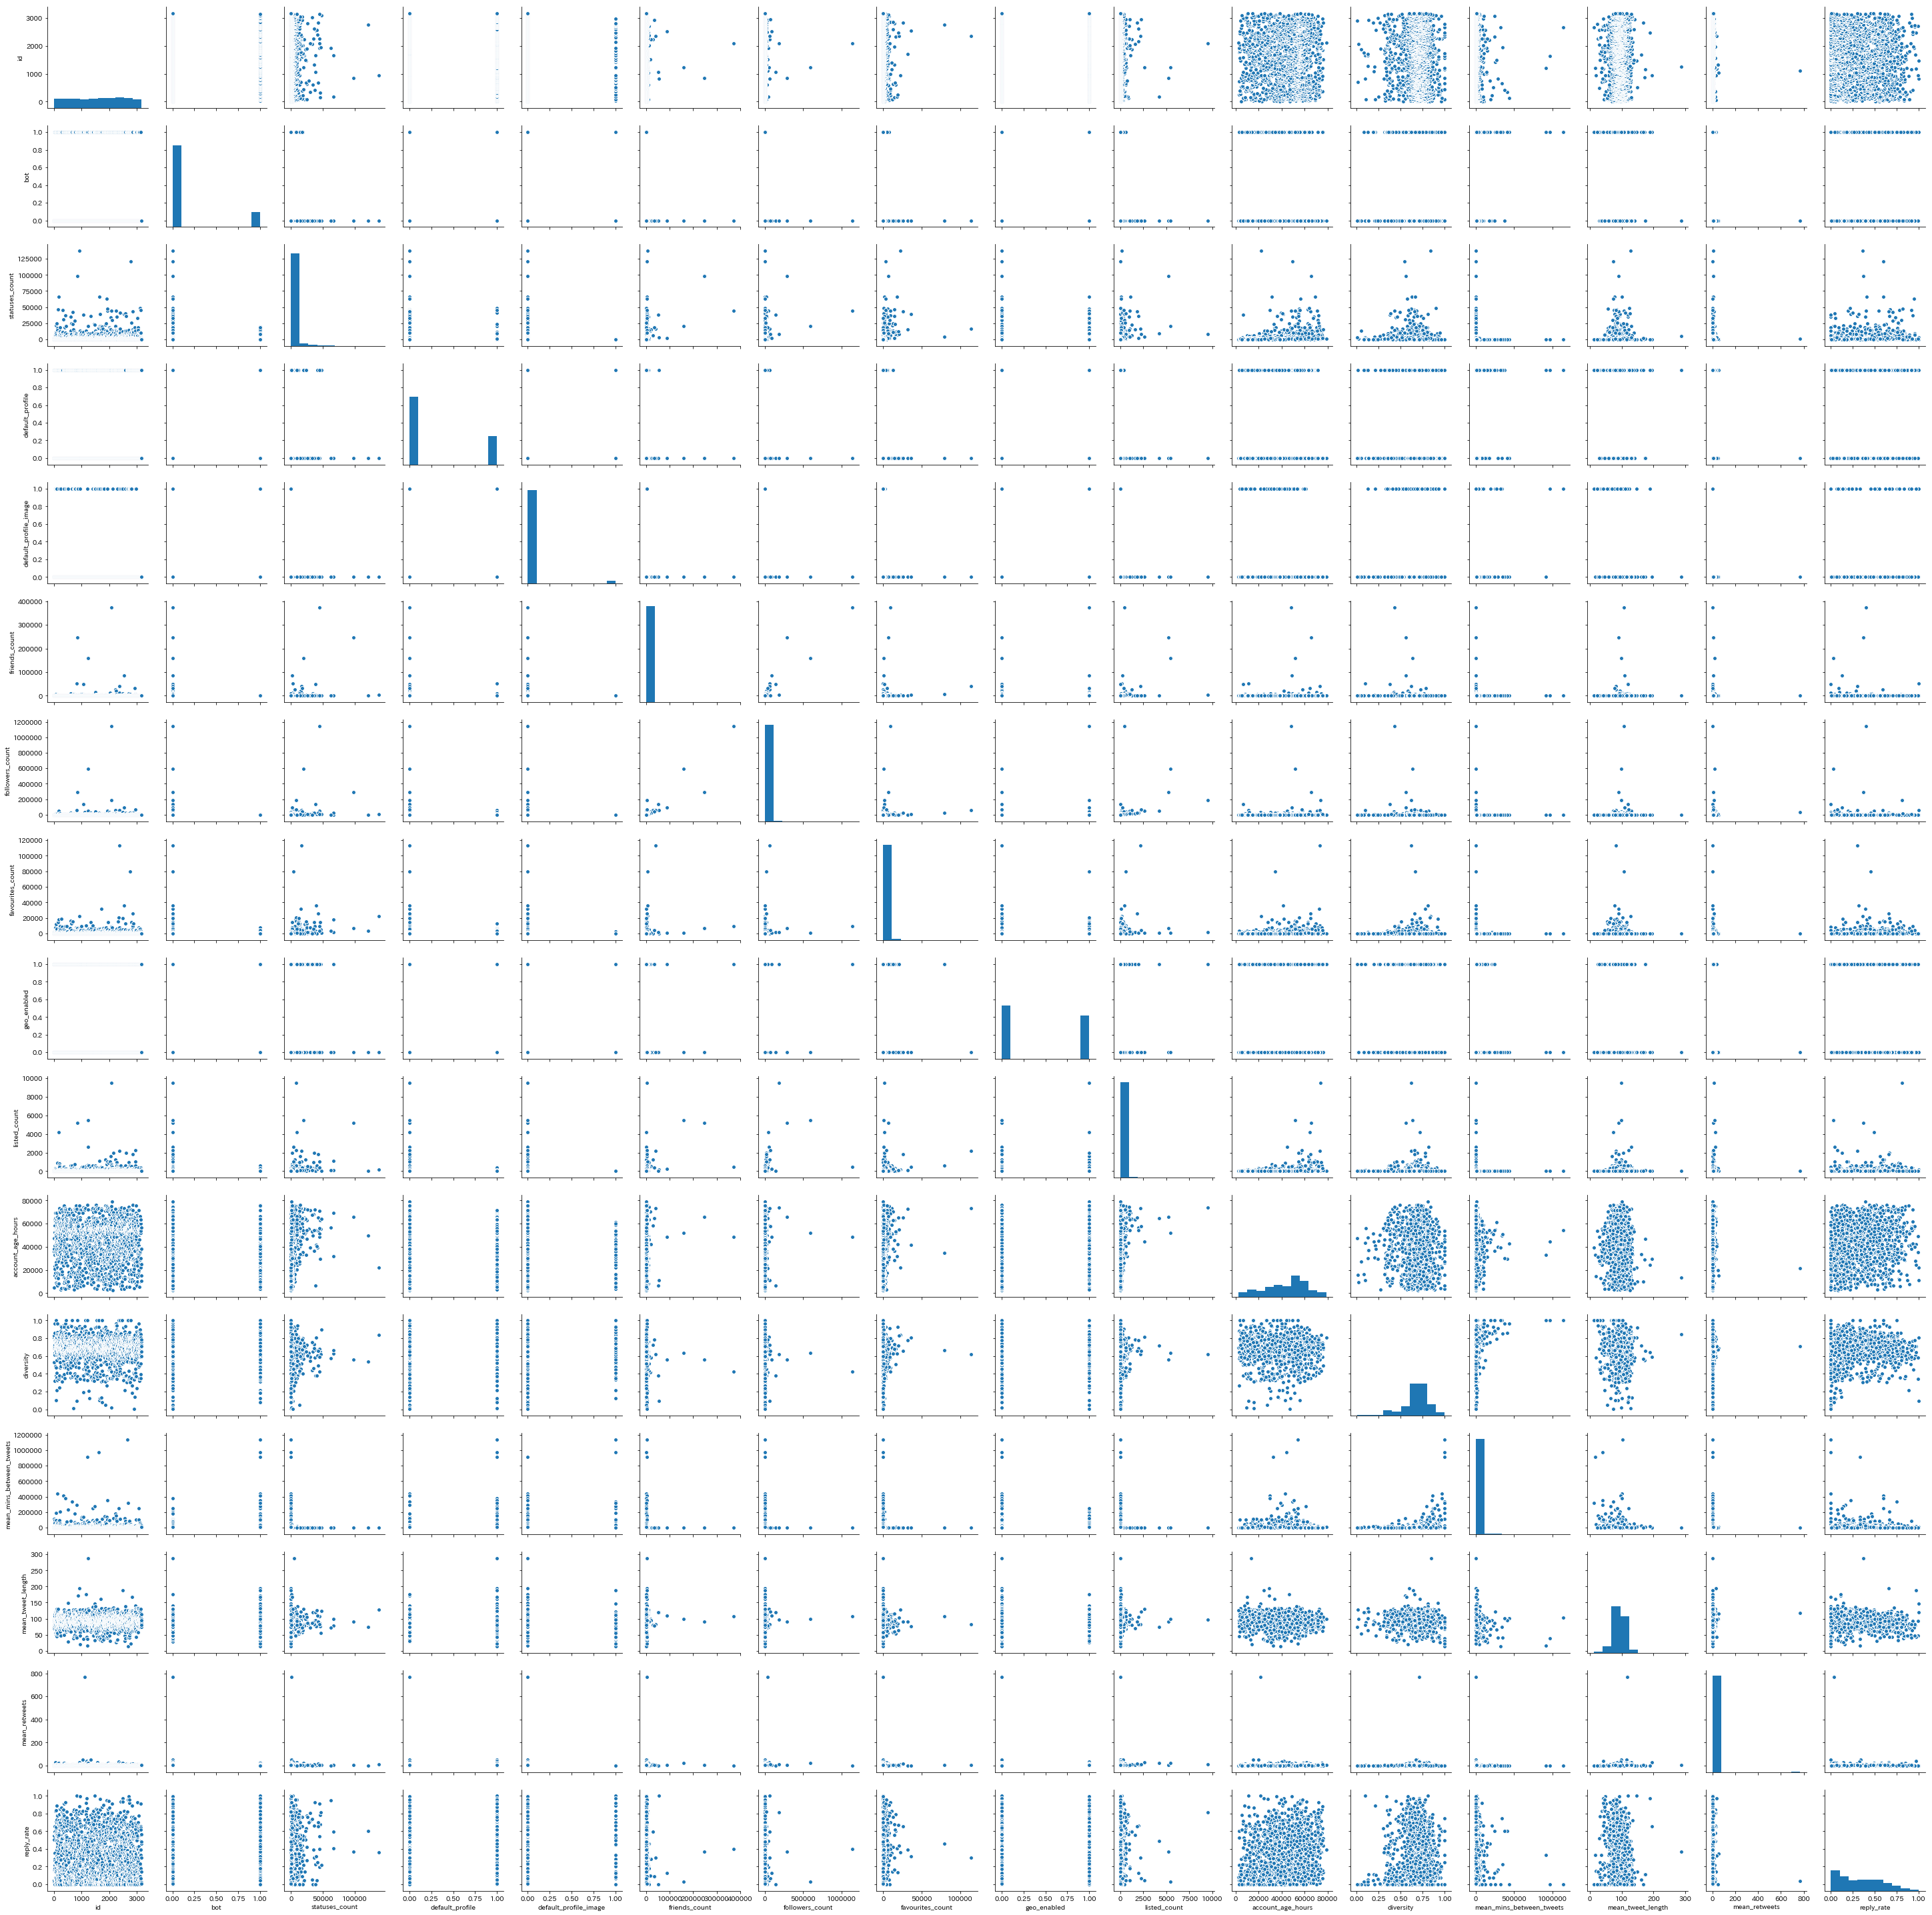

In [9]:
# 項目間の相関をプロット
sns.pairplot(df_train)

In [10]:
# botカラムとの相関が±0.25以上のカラムのみ代入
trainX2 = df_train[["default_profile","default_profile_image","geo_enabled","mean_mins_between_tweets"]]
trainX2.head()

,default_profile,default_profile_image,geo_enabled,mean_mins_between_tweets
0,0,0,1,3958.863636
1,0,0,1,2746.533708
2,0,0,0,11005.031847
3,1,0,0,6495.666667
4,0,0,1,112167.300000


In [11]:
# bot（目的変数）をyに代入する
y = df_train.iloc[:, [1]]
y.head()

,bot
0,0
1,0
2,0
3,0
4,0


### testデータ

In [12]:
# test.tsvの読み込み
df_test = pd.read_csv("test.tsv", sep="\t")
df_test.head()

,id,statuses_count,default_profile,default_profile_image,friends_count,followers_count,favourites_count,geo_enabled,listed_count,account_age_hours,diversity,mean_mins_between_tweets,mean_tweet_length,mean_retweets,reply_rate
0,1,1990,0,0,546,1225,133,0,53,21007,0.869048,2208.218750,90.363636,2.5,0.121212
1,4,601,0,0,948,368,212,0,32,26934,0.612211,292.957143,65.829787,2.0,0.609929
2,5,17,0,0,301,39,1,0,5,25497,0.879310,116383.545455,98.666667,1.0,0.083333
3,6,271,0,0,126,62,3,0,2,70240,0.741379,24589.039682,75.204724,3.0,0.157480
4,8,8,1,0,960,146,24,0,0,12162,0.500000,32.428571,35.750000,1.0,0.250000


In [13]:
testX = df_test.iloc[:, 1:]
testX.head()

,statuses_count,default_profile,default_profile_image,friends_count,followers_count,favourites_count,geo_enabled,listed_count,account_age_hours,diversity,mean_mins_between_tweets,mean_tweet_length,mean_retweets,reply_rate
0,1990,0,0,546,1225,133,0,53,21007,0.869048,2208.218750,90.363636,2.5,0.121212
1,601,0,0,948,368,212,0,32,26934,0.612211,292.957143,65.829787,2.0,0.609929
2,17,0,0,301,39,1,0,5,25497,0.879310,116383.545455,98.666667,1.0,0.083333
3,271,0,0,126,62,3,0,2,70240,0.741379,24589.039682,75.204724,3.0,0.157480
4,8,1,0,960,146,24,0,0,12162,0.500000,32.428571,35.750000,1.0,0.250000


In [14]:
testX.describe()

,statuses_count,default_profile,default_profile_image,friends_count,followers_count,favourites_count,geo_enabled,listed_count,account_age_hours,diversity,mean_mins_between_tweets,mean_tweet_length,mean_retweets,reply_rate
count,1588.000000,1588.000000,1588.000000,1.588000e+03,1.588000e+03,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000
mean,3366.593829,0.284635,0.031486,3.121220e+03,4.509045e+03,1193.340680,0.435768,84.717884,43661.644207,0.681962,15236.606369,90.618457,4.828199,0.338290
std,8979.482737,0.451382,0.174683,3.928165e+04,5.193060e+04,6755.838265,0.496013,326.911562,17931.857774,0.139694,52485.071034,18.332463,57.114252,0.248060
min,0.000000,0.000000,0.000000,1.100000e+01,0.000000e+00,0.000000,0.000000,0.000000,2072.000000,0.005051,-15.654494,8.500000,1.000000,0.000000
25%,180.750000,0.000000,0.000000,2.905000e+02,9.000000e+01,13.000000,0.000000,4.000000,29946.500000,0.625419,1214.966806,80.075553,1.176471,0.125000
50%,689.000000,0.000000,0.000000,5.890000e+02,2.650000e+02,114.000000,0.000000,15.000000,47516.500000,0.697804,4095.136501,91.103788,1.625000,0.305134
75%,2604.750000,1.000000,0.000000,1.227750e+03,7.812500e+02,579.000000,1.000000,47.000000,56824.500000,0.762500,11350.177995,102.596031,2.396875,0.520507
max,134942.000000,1.000000,1.000000,1.175187e+06,1.396699e+06,176219.000000,1.000000,5782.000000,76034.000000,1.000000,792023.000000,176.461538,1961.300000,1.000000


In [15]:
testX.shape

(1588, 14)

In [16]:
testX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1588 entries, 0 to 1587
Data columns (total 14 columns):
statuses_count              1588 non-null int64
default_profile             1588 non-null int64
default_profile_image       1588 non-null int64
friends_count               1588 non-null int64
followers_count             1588 non-null int64
favourites_count            1588 non-null int64
geo_enabled                 1588 non-null int64
listed_count                1588 non-null int64
account_age_hours           1588 non-null int64
diversity                   1588 non-null float64
mean_mins_between_tweets    1588 non-null float64
mean_tweet_length           1588 non-null float64
mean_retweets               1588 non-null float64
reply_rate                  1588 non-null float64
dtypes: float64(5), int64(9)
memory usage: 173.8 KB


In [17]:
testX.isnull().sum()

statuses_count              0
default_profile             0
default_profile_image       0
friends_count               0
followers_count             0
favourites_count            0
geo_enabled                 0
listed_count                0
account_age_hours           0
diversity                   0
mean_mins_between_tweets    0
mean_tweet_length           0
mean_retweets               0
reply_rate                  0
dtype: int64

In [18]:
# botカラムとの相関が±0.25以上のカラムのみ代入
testX2 = df_test[["default_profile","default_profile_image","geo_enabled","mean_mins_between_tweets"]]
testX2.head()

,default_profile,default_profile_image,geo_enabled,mean_mins_between_tweets
0,0,0,0,2208.218750
1,0,0,0,292.957143
2,0,0,0,116383.545455
3,0,0,0,24589.039682
4,1,0,0,32.428571


### 交差検証

In [19]:
# 交差検証　Holdout法
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(trainX,
                                                 y,
                                                 test_size=0.30,
                                                 random_state=1)

In [20]:
# 整形
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# set pipelines for three different algorithms
pipe_LR = Pipeline([('scl',StandardScaler()),
                       ('est',LogisticRegression(random_state=1))])
pipe_RF = Pipeline([('scl',StandardScaler()),
                        ('est',RandomForestClassifier(random_state=1))])
pipe_GB = Pipeline([('scl',StandardScaler()),
                        ('est',GradientBoostingClassifier(random_state=1))])
pipe_PCARF = Pipeline([('scl',StandardScaler()),
                          ('est',PCA(random_state=1)),
                          ('rfc',RandomForestClassifier(random_state=1))])
pipe_SVC = Pipeline([('scl',StandardScaler()),
                          ('est',LinearSVC(random_state=1))])
pipe_KNC = Pipeline([('scl',StandardScaler()),
                          ('est',KNeighborsClassifier())])

In [22]:
# 学習
pipe_LR.fit(X_train, y_train)
pipe_RF.fit(X_train, y_train)
pipe_GB.fit(X_train, y_train)
pipe_PCARF.fit(X_train, y_train)
pipe_SVC.fit(X_train, y_train)
pipe_KNC.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('est', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [23]:
# 評価（f1スコアとする）
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

print('pipe_LR_Train:%.3f'% f1_score(y_train,
                                          pipe_LR.predict(X_train)))
print('pipe_LR_Test:%.3f' % f1_score(y_test,
                                          pipe_LR.predict(X_test)))

print('pipe_RF_Train:%.3f'% f1_score(y_train,
                                          pipe_RF.predict(X_train)))
print('pipe_RF_Test:%.3f' % f1_score(y_test,
                                          pipe_RF.predict(X_test)))

print('pipe_GB_Train:%.3f'% f1_score(y_train,
                                          pipe_GB.predict(X_train)))
print('pipe_GB_Test:%.3f' % f1_score(y_test,
                                          pipe_GB.predict(X_test)))

print('pipe_PCARF_Train:%.3f'% f1_score(y_train,
                                          pipe_PCARF.predict(X_train)))
print('pipe_PCARF_Test:%.3f' % f1_score(y_test,
                                          pipe_PCARF.predict(X_test)))

print('pipe_SVC_Train:%.3f'% f1_score(y_train,
                                          pipe_SVC.predict(X_train)))
print('pipe_SVC_Test:%.3f' % f1_score(y_test,
                                          pipe_SVC.predict(X_test)))

print('pipe_KNC_Train:%.3f'% f1_score(y_train,
                                          pipe_KNC.predict(X_train)))
print('pipe_KNC_Test:%.3f' % f1_score(y_test,
                                          pipe_KNC.predict(X_test)))

pipe_LR_Train:0.470
pipe_LR_Test:0.396
pipe_RF_Train:0.964
pipe_RF_Test:0.648
pipe_GB_Train:0.962
pipe_GB_Test:0.720
pipe_PCARF_Train:0.961
pipe_PCARF_Test:0.490
pipe_SVC_Train:0.412
pipe_SVC_Test:0.349
pipe_KNC_Train:0.580
pipe_KNC_Test:0.431


#### Gradient Boosting Classifier を採用する

In [24]:
# パラメータグリッドの設定
from sklearn.model_selection import GridSearchCV
param_grid_GB = {'est__loss':['deviance','exponential'],
#                  'est__learning_rate':[0.001,0.01,0.1],
#                  'est__n_estimators':[5,10,50,100,500], 
                 'est__max_depth':[1,2,3,4,5],
                 'est__min_samples_split':[0.1,0.3,0.5,0.7,0.9],
                 'est__min_samples_leaf':[1,2,4,6,8] }

# loss：最小化にするための費用関数　標準値deviance
# learning_rate：標準値0.1　結果に対する各ツリーの影響度を小さくする。↓に反比例。小さいほどロバスト性が高く良い
# n_estimators：標準値100　逐次的にフィットするためrのツリー数↑に対して交差検証から調整 
# max_depth：標準値設定なし　各ツリーの最大深さ　
# min_samples_split：標準値2　ノードとして必要な最小サンプル数
# min_samples_leaf：標準値1　リーフとして必要な最小サンプル数

In [25]:
# write your answer
print('探索空間:%s' %param_grid_GB)
clf = GridSearchCV(estimator=pipe_GB,
                   param_grid=param_grid_GB,
                   scoring='f1',
                   cv=3,
                   return_train_score=False)
clf = clf.fit(X_train, y_train)
print('Best Score:', clf.best_score_)
print('Best Params', clf.best_params_)

探索空間:{'est__loss': ['deviance', 'exponential'], 'est__max_depth': [1, 2, 3, 4, 5], 'est__min_samples_split': [0.1, 0.3, 0.5, 0.7, 0.9], 'est__min_samples_leaf': [1, 2, 4, 6, 8]}
Best Score: 0.728403353386644
Best Params {'est__loss': 'exponential', 'est__max_depth': 4, 'est__min_samples_leaf': 8, 'est__min_samples_split': 0.1}


In [26]:
pred = pipe_GB.predict(testX)
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### 提出用CSVの作成

In [27]:
sample = pd.read_csv("sample_submit.csv",header=None)
sample.head()

,0,1
0,1,1
1,4,1
2,5,0
3,6,1
4,8,0


In [28]:
sample[1]=pred

In [29]:
sample.to_csv("submit3.csv",index=None,header=None)